This notebook demonstrates an experiment.
As an example, Field-weighted Factorization Machine: https://arxiv.org/abs/1806.03514 is used.

In [1]:
import datetime
import os
import pickle
from pathlib import Path

import itertools
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tqdm import tqdm
from pandas import DataFrame

from src.config import TrainConfig
from src.data.data_generator import DataGenerator
from src.data import preprocessors
from src.losses import pairwise_losses
from src.utils.seed import set_seed
from src.utils.plot import plot_history
from src.metrics import metrics
from src.models.base_model import BaseModel
from src.layers.bias import AddBias0

import matplotlib.pyplot as plt
import seaborn as sns

project_dir = '../..'

In [2]:
from src.data.recipes import load_raw_recipes

recipes = load_raw_recipes()
data_processor = preprocessors.ConcatDataProcessor(recipes)

In [3]:
def get_field_weights(model):
    weight_names = [weight.name for layer in model.layers for weight in layer.weights]
    w = None
    for name, weight in zip(weight_names, model.get_weights()):
        if 'field_weights' in name:
            w = weight
    for i in range(5):
        w[i][i] = None
    for i, j in itertools.combinations(range(5), 2):
        w[j][i] = w[i][j]
    return w

def show_field_weights(model):
    w = get_field_weights(model)
    label = ['query', 'title', 'ingredients', 'description', 'country']
    sns.heatmap(w, xticklabels=label, yticklabels=label, annot=True)
    plt.show()

In [13]:
class WeightedFeatureInteraction(tf.keras.layers.Layer):
    def __init__(self, num_fields, **kwargs):
        self.num_fields = num_fields
        super(WeightedFeatureInteraction, self).__init__(**kwargs)

    def build(self, input_shape):
        w_init = tf.constant_initializer(value=0)
        self.field_weights = tf.Variable(
            initial_value=w_init(shape=(self.num_fields, self.num_fields), dtype=tf.float32),
            name='field_weights',
        )
        self.dot = layers.Dot(axes=1, normalize=True)
        super(WeightedFeatureInteraction, self).build(input_shape)

    def call(self, inputs):
        dim = inputs.shape[1] // self.num_fields
        interactions = []
        for i, j in itertools.combinations(range(self.num_fields), 2):
            feature1, feature2 = inputs[:, i*dim:(i+1)*dim], inputs[:, j*dim:(j+1)*dim]
            interaction = self.dot([feature1, feature2])
            interaction = tf.math.scalar_mul(self.field_weights[i, j], interaction)
            interactions.append(interaction)
        return layers.concatenate(interactions)
    
    def compute_output_shape(self, input_shape):
        return None, self.num_fields

    def get_config(self):
        config = super(WeightedFeatureInteraction, self).get_config().copy()
        config.update({
            'num_fields': self.num_fields,
        })
        return config
    
class FwFMAll(BaseModel):
    @property
    def name(self) -> str:
        return 'fwfm_all'

    def build(self):
        text_inputs = [
            self.new_query_input(),
            self.new_title_input(),
            self.new_ingredients_input(),
            self.new_description_input(),
        ]
        country_input = tf.keras.Input(shape=(1,), name='country')
        inputs = text_inputs + [country_input]

        word_embedding = layers.Embedding(self.total_words, self.embedding_dim, name='text_embedding')
        text_features = [word_embedding(text_input) for text_input in text_inputs]
        text_features = [layers.GlobalMaxPooling1D()(feature) for feature in text_features]
        country_embedding = layers.Embedding(self.total_countries, self.embedding_dim)
        country = country_embedding(country_input)
        country = tf.reshape(country, shape=(-1, self.embedding_dim,))
        input_features = text_features + [country]

        interactions = []
        num_fields = len(input_features)
        features = tf.concat(input_features, axis=1)
        weighted_interaction = WeightedFeatureInteraction(num_fields)
        interactions = weighted_interaction(features)
        
        features = []
        for feature in input_features:
            feature = layers.Dense(1, activation='relu')(feature)
            features.append(feature)
        features = tf.concat(features, axis=1)
        
        x = tf.concat([features, interactions], axis=1)
        visualizer = tf.keras.Model(inputs=inputs, outputs=x)
        x = tf.keras.backend.sum(x, axis=1, keepdims=True)
        output = layers.Activation('sigmoid', name='label')(x)
        return tf.keras.Model(inputs=inputs, outputs=output, name=self.name), visualizer

In [14]:
dataset_id = 0
config = TrainConfig(
    dataset=f'listwise.{dataset_id}',
    data_processor=data_processor,
    data_processor_filename=f'concat_data_processor.{dataset_id}',
    model=FwFMAll,
    epochs=6,
)

In [8]:
data_processor = config.data_processor
train_df = data_processor.listwise_to_pairs(f'{config.dataset}.train.pkl')
val_df = data_processor.listwise_to_pairs(f'{config.dataset}.val.pkl')
data_processor.fit(train_df)

train_generator = DataGenerator(train_df, data_processor)
val_generator = DataGenerator(val_df, data_processor)

100%|██████████| 15533/15533 [00:00<00:00, 149909.28it/s]


Model: "fwfm_all"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
query (InputLayer)              [(None, 6)]          0                                            
__________________________________________________________________________________________________
title (InputLayer)              [(None, 20)]         0                                            
__________________________________________________________________________________________________
ingredients (InputLayer)        [(None, 300)]        0                                            
__________________________________________________________________________________________________
description (InputLayer)        [(None, 100)]        0                                            
___________________________________________________________________________________________

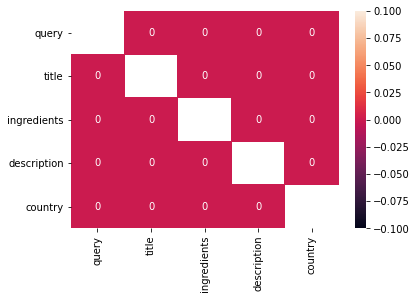

In [16]:
model, visualizer = config.model(data_processor).build()
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss={'label': pairwise_losses.cross_entropy_loss},
    metrics=['accuracy']
)
model.summary()
show_field_weights(model)

In [17]:
history = model.fit(
    train_generator,
    epochs=config.epochs,
    validation_data=val_generator,
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2286 steps, validate for 1031 steps
Epoch 1/6
2286/2286 [==============================] - 244s 107ms/step - loss: 0.6334 - accuracy: 0.6162 - val_loss: 0.5984 - val_accuracy: 0.6577 loss: 0.6335 - accura
Epoch 2/6
2286/2286 [==============================] - 253s 111ms/step - loss: 0.5594 - accuracy: 0.7071 - val_loss: 0.5772 - val_accuracy: 0.6779
Epoch 3/6
2286/2286 [==============================] - 233s 102ms/step - loss: 0.5283 - accuracy: 0.7431 - val_loss: 0.5687 - val_accuracy: 0.6849
Epoch 4/6
2286/2286 [==============================] - 230s 100ms/step - loss: 0.5114 - accuracy: 0.7608 - val_loss: 0.5655 - val_accuracy: 0.6893
Epoch 5/6
2286/2286 [==============================] - 249s 109ms/step - loss: 0.4998 - accuracy: 0.7742 - val_loss: 0.5649 - val_accuracy: 0.6874
Epoch 6/6
2286/2286 [==============================] - 237s 104ms/step - loss: 0.4919 - accuracy: 0.7823 - val_loss: 0.5628 - val_accuracy: 0.6912


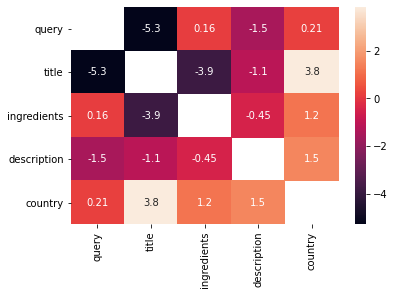

In [31]:
show_field_weights(model)

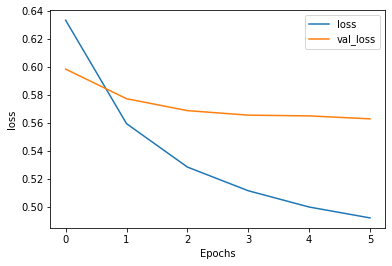

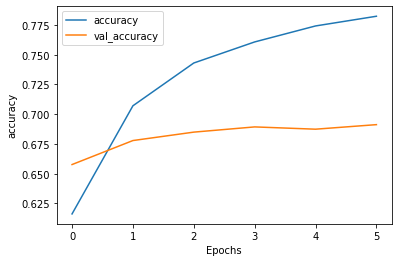

In [18]:
plot_history(history, 'loss')
plot_history(history, 'accuracy')

(0.6912, 0.7359, 0.5965)

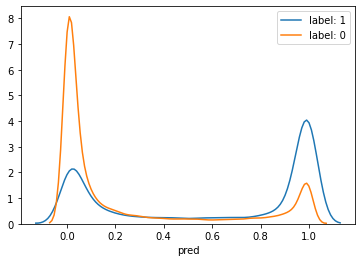

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

val_df['pred'] = model.predict(val_generator)

temp = val_df[val_df['label'] == 1]
sns.distplot(temp['pred'], hist=False, label='label: 1')
temp = val_df[val_df['label'] == 0]
sns.distplot(temp['pred'], hist=False, label='label: 0')

y_true = val_df['label']
y_pred = val_df['pred']
round(accuracy_score(y_true, y_pred > 0.5), 4), round(precision_score(y_true, y_pred > 0.5), 4), round(recall_score(y_true, y_pred > 0.5), 4)

In [21]:
features = [
    'query', 'title', 'ingredients', 'description', 'country',
    'query-title', 'query-ingredients', 'query-description', 'query-country',
    'title-ingredients', 'title-description', 'title-country',
    'ingredients-description', 'ingredients-country',
    'description-country'
]

In [33]:
output = visualizer.predict(val_generator)
output_with_label = np.concatenate([output, val_df['label'].to_numpy().reshape((-1,1))], axis=1)
columns = features + ['label']
output_df = DataFrame(output_with_label, columns=columns)
positive_output_df = output_df[output_df['label'] == 1]
negative_output_df = output_df[output_df['label'] == 0]

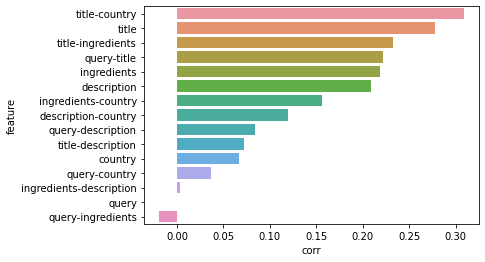

In [27]:
corr_df = output_df.corr()
corr_df = corr_df[['label']].sort_values(by='label', ascending=False).reset_index()
corr_df = corr_df.rename(columns={'index': 'feature', 'label': 'corr'})
corr_df = corr_df[~(corr_df['feature'] == 'label')]
plt.figure(figsize=(6,4))
sns.barplot(data=corr_df, x='corr', y='feature')

/Users/kentaro-takiguchi/workspace/master-thesis/.venv/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/kentaro-takiguchi/workspace/master-thesis/.venv/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


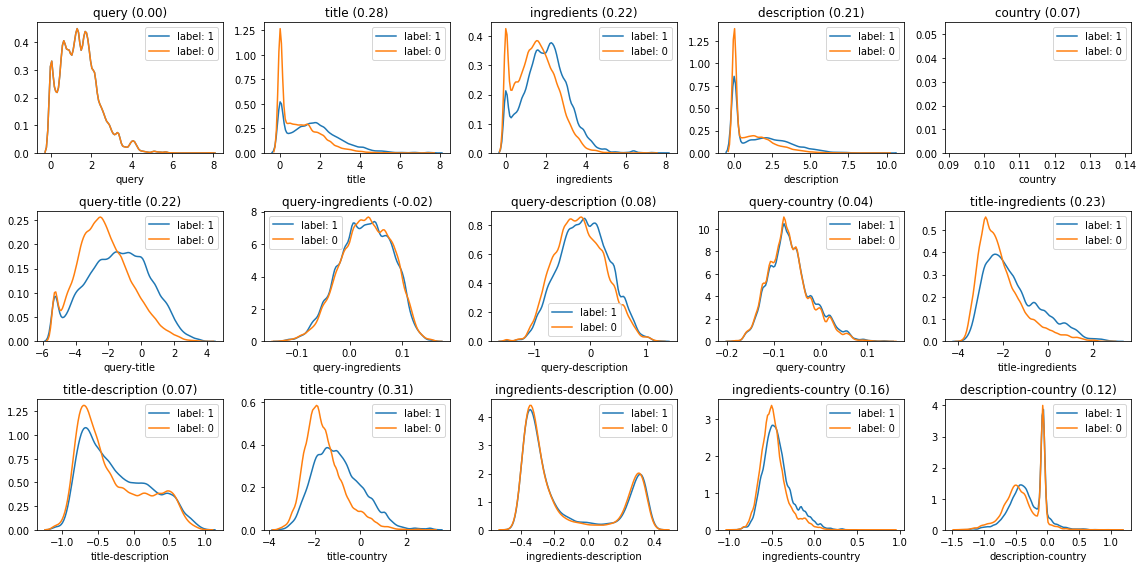

In [35]:
def plot_dist(feature, ax):
    sns.distplot(positive_output_df[feature], hist=False, label='label: 1', ax=ax)
    sns.distplot(negative_output_df[feature], hist=False, label='label: 0', ax=ax)
    
def significance(feature):
    return corr_df[corr_df['feature'] == feature]['corr'].iloc[0]

fig, axes = plt.subplots(3, 5, figsize=(16,8))
for i in range(3):
    for j in range(5):
        idx = i * 5 + j
        if idx < len(features):
            feature = features[idx]
            plot_dist(feature, axes[i][j])
            sig = significance(feature)
            axes[i][j].set_title(f'{feature} ({sig:.2f})')
        else:
            axes[i][j].set_axis_off()
fig.tight_layout()

In [22]:
from IPython.core.display import HTML

def explain(idx, query=None, attrs=None):
    sample = val_df.iloc[idx].copy()
    recipe = recipes[sample['doc_id']].copy()
    if query:
        sample['query'] = query
    if attrs:
        sample['doc_id'] = -1
        recipe['recipe_id'] = -1
        recipe['title'] = attrs['title']
        recipe['ingredients'] = attrs['ingredients']
        recipe['story_or_description'] = attrs['description']
        recipe['country'] = attrs['country']
        data_processor.recipes[-1] = recipe
    samples_df = sample.to_frame().T
    display(samples_df)
    display(HTML(f"<b>query</b>: {sample['query']}"))
    display(HTML(f"<b>title</b>: {recipe['title']}"))
    display(HTML(f"<b>ingredients</b>: {','.join(recipe['ingredients'])}"))
    display(HTML(f"<b>description</b>: {recipe['story_or_description']}"))
    display(HTML(f"<b>country</b>: {recipe['country']}"))
    data = data_processor.process_batch(samples_df)
    dataset = tf.data.Dataset.from_tensor_slices((data))
    generator = dataset.cache().batch(1)
    pred = model.predict(generator)[0][0]
    display(HTML(f"<b>pred</b>: {pred:.2f}"))
    output = visualizer.predict(generator)[0]
    rows = []
    for i in range(len(features)):
        rows.append({
            'feature': features[i],
            'value': output[i],
        })
    temp = DataFrame(rows).sort_values(by=['value'], ascending=False)
    plt.figure(figsize=(6,4))
    sns.barplot(data=temp, x='value', y='feature')
    plt.show()

,query,doc_id,label,pred
20486,snow crab,371827,1,0.981341


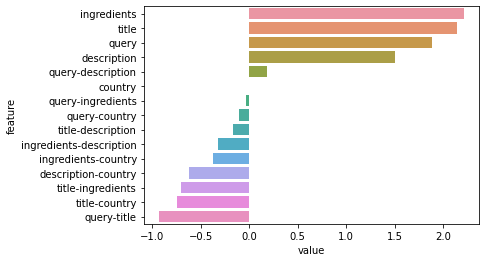

,query,doc_id,label,pred
20487,snow crab,328645,0,0.0180401


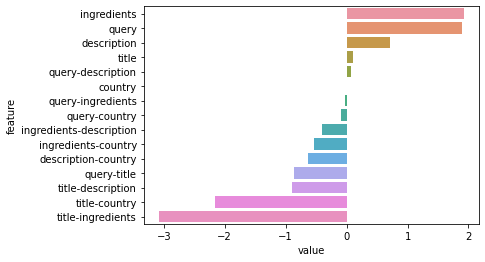

In [24]:
explain(20486) # breakfast positive
explain(20487) # breakfast negative

,query,doc_id,label,pred
5812,shrimp,-1,1,0.0480494


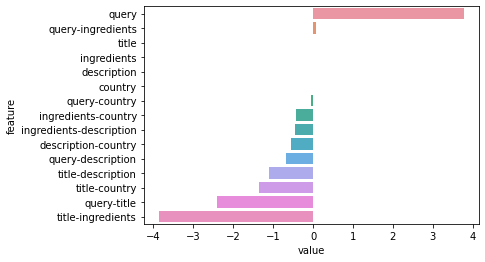

,query,doc_id,label,pred
5812,shrimp,-1,1,0.0480494


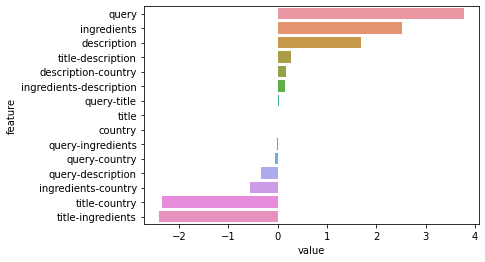

In [25]:
explain(
    idx=5812,
    query='shrimp',
    attrs={
        'title': 'water',
        'ingredients': ['water'],
        'description': 'water',
        'country': 'US'
    }
)

explain(
    idx=5812,
    query='shrimp',
    attrs={
        'title': 'Tasty bisque with shrimps',
        'ingredients': ['onion', 'carrots', 'leek', 'tomato', 'shirmps', 'garlic'],
        'description': 'Yummy',
        'country': 'US'
    }
)